# NYSE Time Series

# Import Libraries

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab

from math import sqrt, ceil
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from pmdarima import auto_arima
import pickle


## Data Loading and Cleaning

In [38]:
# Read the CSV file into a DataFrame
df = pd.read_csv('stock_raw.csv')

# Display the first few rows of the DataFrame
df.head()

,date,year,month,day,symbol,Security,GICS Sector,GICS Sub Industry,open,close,low,high,volume,price_direction
0,2016-01-05,2016,1,5,WLTW,Willis Towers Watson,Financials,Insurance Brokers,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996
1,2016-01-06,2016,1,6,WLTW,Willis Towers Watson,Financials,Insurance Brokers,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995
2,2016-01-07,2016,1,7,WLTW,Willis Towers Watson,Financials,Insurance Brokers,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000
3,2016-01-08,2016,1,8,WLTW,Willis Towers Watson,Financials,Insurance Brokers,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000
4,2016-01-11,2016,1,11,WLTW,Willis Towers Watson,Financials,Insurance Brokers,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               851264 non-null  object 
 1   year               851264 non-null  int64  
 2   month              851264 non-null  int64  
 3   day                851264 non-null  int64  
 4   symbol             851264 non-null  object 
 5   Security           851264 non-null  object 
 6   GICS Sector        851264 non-null  object 
 7   GICS Sub Industry  851264 non-null  object 
 8   open               851264 non-null  float64
 9   close              851264 non-null  float64
 10  low                851264 non-null  float64
 11  high               851264 non-null  float64
 12  volume             851264 non-null  float64
 13  price_direction    851264 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 90.9+ MB


In [40]:
df.duplicated().sum()

0

No duplicates and no missing values.

In [41]:
# Change date to datetime
df['date'] = pd.to_datetime(df['date'])

In [42]:
# Convert DataFrame's index into a DatetimeIndex
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [43]:
df.tail(10)

,year,month,day,symbol,Security,GICS Sector,GICS Sub Industry,open,close,low,high,volume,price_direction
date,,,,,,,,,,,,,
2016-12-30,2016,12,30,XRAY,Dentsply Sirona,Health Care,Health Care Supplies,58.290001,57.730000,57.540001,58.360001,949200.0,-0.560001
2016-12-30,2016,12,30,XRX,Xerox Corp.,Information Technology,IT Consulting & Other Services,8.720000,8.730000,8.700000,8.800000,11250400.0,0.010000
2016-12-30,2016,12,30,XYL,Xylem Inc.,Industrials,Industrial Conglomerates,49.980000,49.520000,49.360001,50.000000,646200.0,-0.460000
2016-12-30,2016,12,30,YHOO,Yahoo Inc.,Information Technology,Internet Software & Services,38.720001,38.669998,38.430000,39.000000,6431600.0,-0.050003
2016-12-30,2016,12,30,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,63.930000,63.330002,63.160000,63.939999,1887100.0,-0.599998
2016-12-30,2016,12,30,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001
2016-12-30,2016,12,30,ZION,Zions Bancorp,Financials,Regional Banks,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999
2016-12-30,2016,12,30,ZTS,Zoetis,Health Care,Pharmaceuticals,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000
2016-12-30,2016,12,30,AIV,Apartment Investment & Mgmt,Real Estate,REITs,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001


In [44]:
df['year'].unique()

array([2016, 2010, 2011, 2012, 2013, 2014, 2015])

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               851264 non-null  int64  
 1   month              851264 non-null  int64  
 2   day                851264 non-null  int64  
 3   symbol             851264 non-null  object 
 4   Security           851264 non-null  object 
 5   GICS Sector        851264 non-null  object 
 6   GICS Sub Industry  851264 non-null  object 
 7   open               851264 non-null  float64
 8   close              851264 non-null  float64
 9   low                851264 non-null  float64
 10  high               851264 non-null  float64
 11  volume             851264 non-null  float64
 12  price_direction    851264 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 90.9+ MB


In [46]:
aapl_df = df[df['symbol'] == 'AAPL']
aapl_df.head()

,year,month,day,symbol,Security,GICS Sector,GICS Sub Industry,open,close,low,high,volume,price_direction
date,,,,,,,,,,,,,
2010-01-04,2010,1,4,AAPL,Apple Inc.,Information Technology,Computer Hardware,30.490000,30.572857,30.340000,30.642857,123432400.0,0.082857
2010-01-05,2010,1,5,AAPL,Apple Inc.,Information Technology,Computer Hardware,30.657143,30.625713,30.464285,30.798571,150476200.0,-0.031429
2010-01-06,2010,1,6,AAPL,Apple Inc.,Information Technology,Computer Hardware,30.625713,30.138571,30.107143,30.747143,138040000.0,-0.487143
2010-01-07,2010,1,7,AAPL,Apple Inc.,Information Technology,Computer Hardware,30.250000,30.082857,29.864286,30.285715,119282800.0,-0.167143
2010-01-08,2010,1,8,AAPL,Apple Inc.,Information Technology,Computer Hardware,30.042856,30.282858,29.865715,30.285715,111902700.0,0.240002


In [47]:
aapl_df = aapl_df.drop(['year', 'month', 'day', 'symbol', 'Security', 'GICS Sector', 'GICS Sub Industry', 'open', 'low', 'high', 'volume', 'price_direction'], axis=1)

## EDA

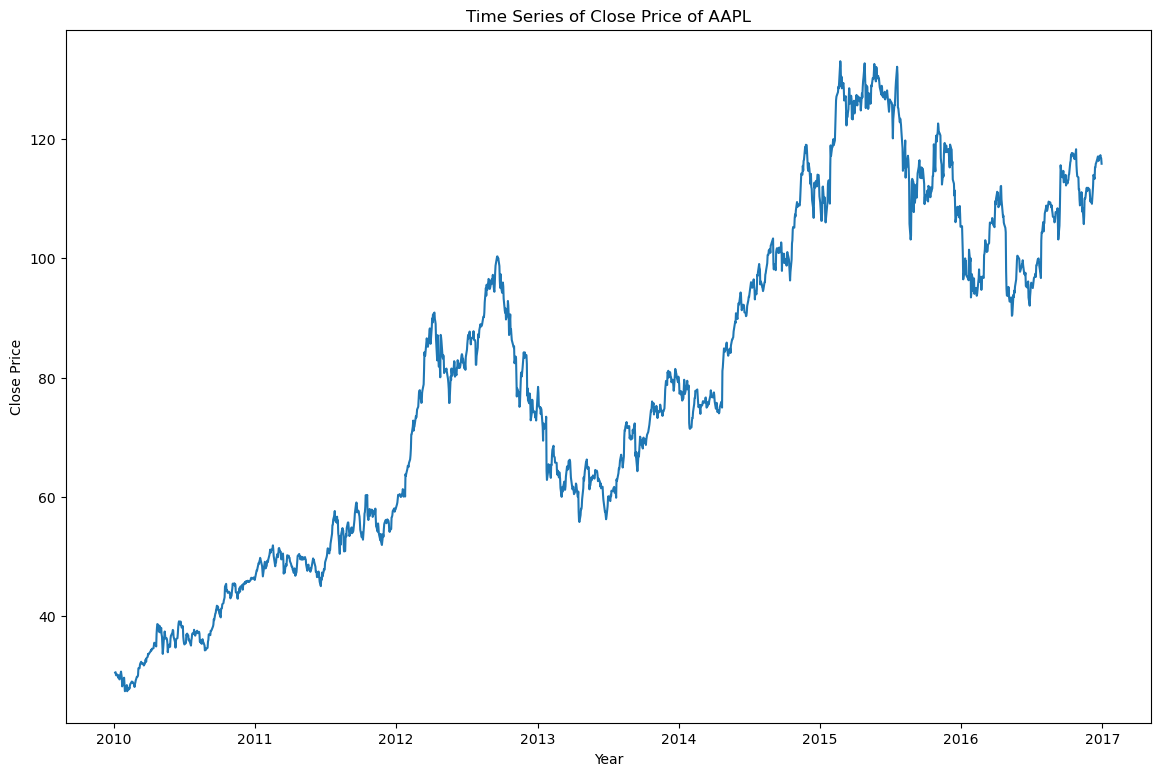

In [48]:
# Plot the time series
plt.figure(figsize=(14, 9))
plt.plot(aapl_df.index, aapl_df['close'])
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Time Series of Close Price of AAPL')
plt.show()

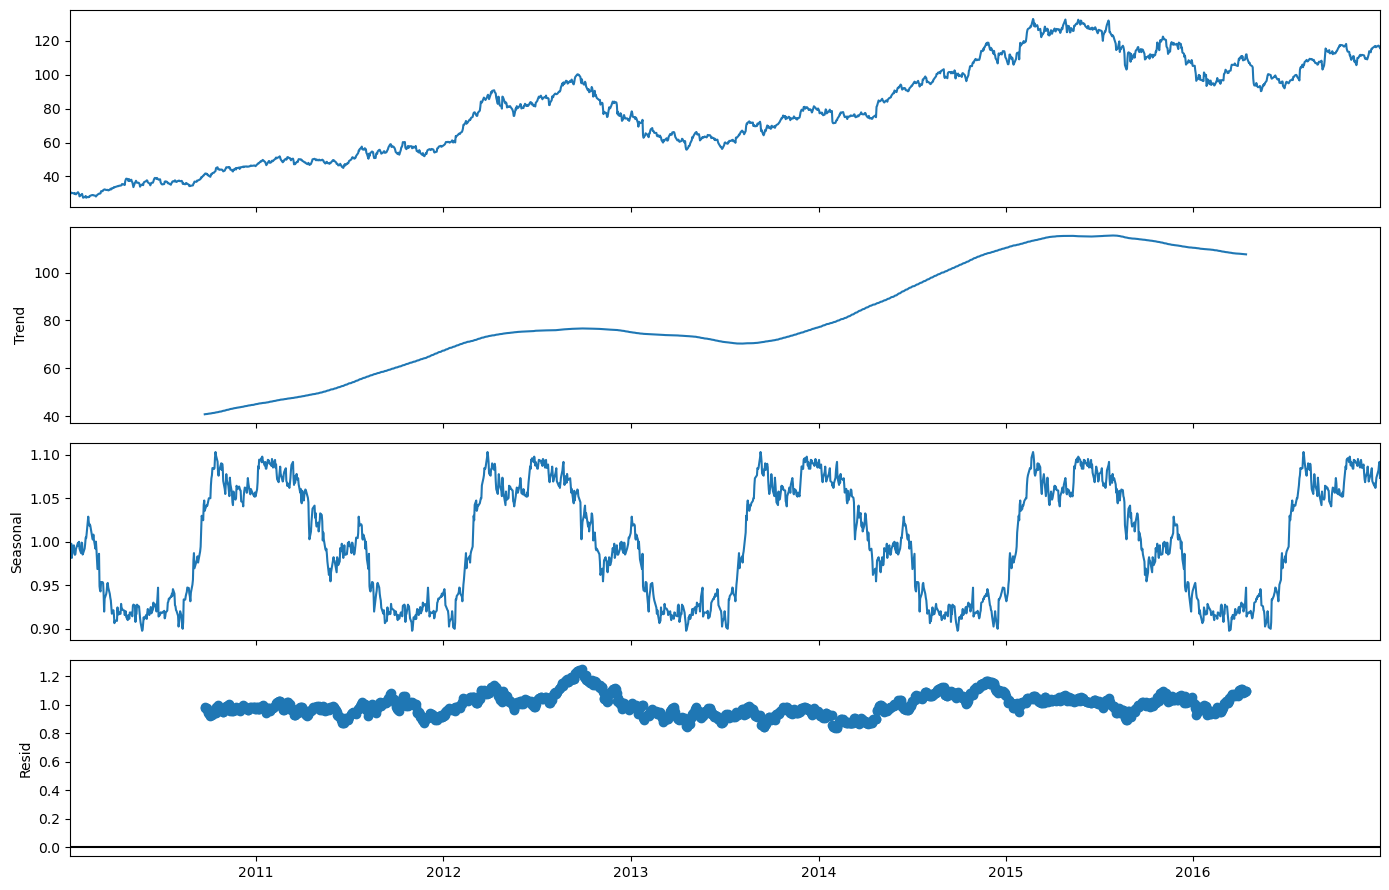

In [49]:
# Decompose the components from the time series
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(aapl_df, model='multiplicative', period=365)
ax = res.plot()
plt.show()

Here we resampled the data to remove noise then continue on to decomposition. We've adjusted the period to be 365 for yearly seasonality

# Check Stationary

In [50]:
# create function to check stationarity
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [51]:
# Check stationarity of the dataset

check_stationarity(aapl_df['close'])

ADF Statistic: -1.324458
p-value: 0.617910
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Non-stationary


In [52]:
# Perform first-order differencing

diff1 = aapl_df['close'].diff()
diff1

date
2010-01-04         NaN
2010-01-05    0.052856
2010-01-06   -0.487143
2010-01-07   -0.055714
2010-01-08    0.200001
                ...   
2016-12-23    0.229996
2016-12-27    0.740005
2016-12-28   -0.500000
2016-12-29   -0.029999
2016-12-30   -0.910003
Name: close, Length: 1762, dtype: float64

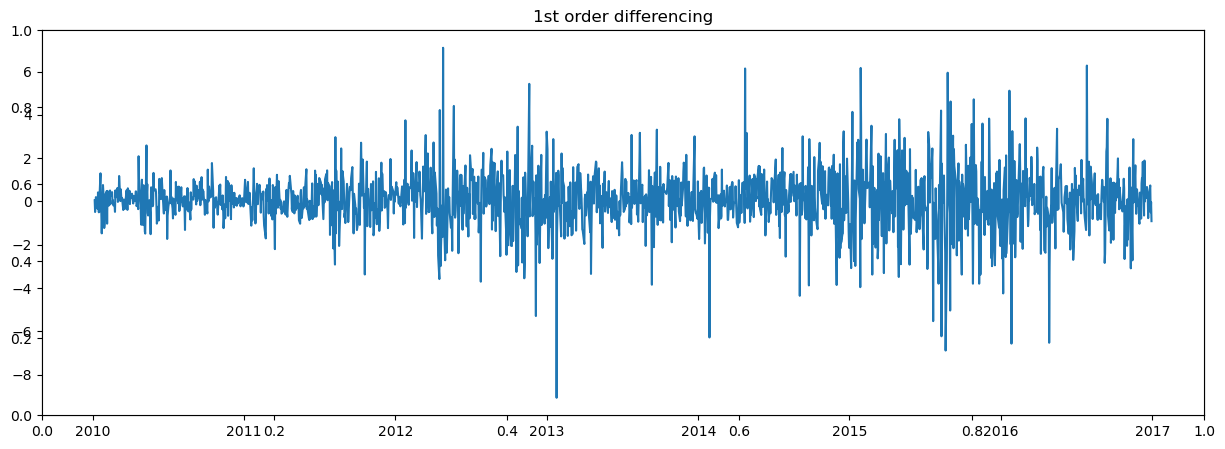

In [53]:
# Plot the result after first-order differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('1st order differencing')
ax1.plot(diff1)

In [54]:
# Check stationarity after performing first-order differencing

print("1st order differencing")
check_stationarity(diff1.dropna())

1st order differencing
ADF Statistic: -41.122158
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


# Model Selection

## ARIMA

In [75]:
def arima_prediction(data):
    shape = data.shape[0]
    aapl_df = data[['close']]
    aapl_df['close'] = np.log(aapl_df['close'])  # Apply logarithmic transformation
    
    train_set = aapl_df.iloc[:ceil(shape * 0.9)]
    valid_set = aapl_df.iloc[ceil(shape * 0.9):]
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    training = train_set['close']
    validation = valid_set['close']
    model = auto_arima(training, start_p=0, start_q=0, max_p=3, max_q=3, start_P=0, seasonal=True,m=12, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(training)

    # Save the model to a file
    with open('arima_model.pkl', 'wb') as pkl_file:
        pickle.dump(model, pkl_file)

    forecast = model.predict(n_periods=len(validation))
    forecast.index = validation.index
    forecast = pd.DataFrame(forecast,columns =['Prediction'])
    #forecast = pd.DataFrame(forecast, index=valid_set.index, columns=['Prediction'])
    rms = np.sqrt(np.mean(np.power((np.array(validation) - np.array(forecast['Prediction'])), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    plt.plot(train_set['close'])
    plt.plot(valid_set['close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Auto ARIMA', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])

----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set: (1586, 1)
Shape of Validation Set: (176, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-7292.366, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-7757.476, Time=0.56 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-7290.380, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-7898.921, Time=1.46 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-7899.852, Time=1.50 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-7759.211, Time=0.25 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=5.5

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


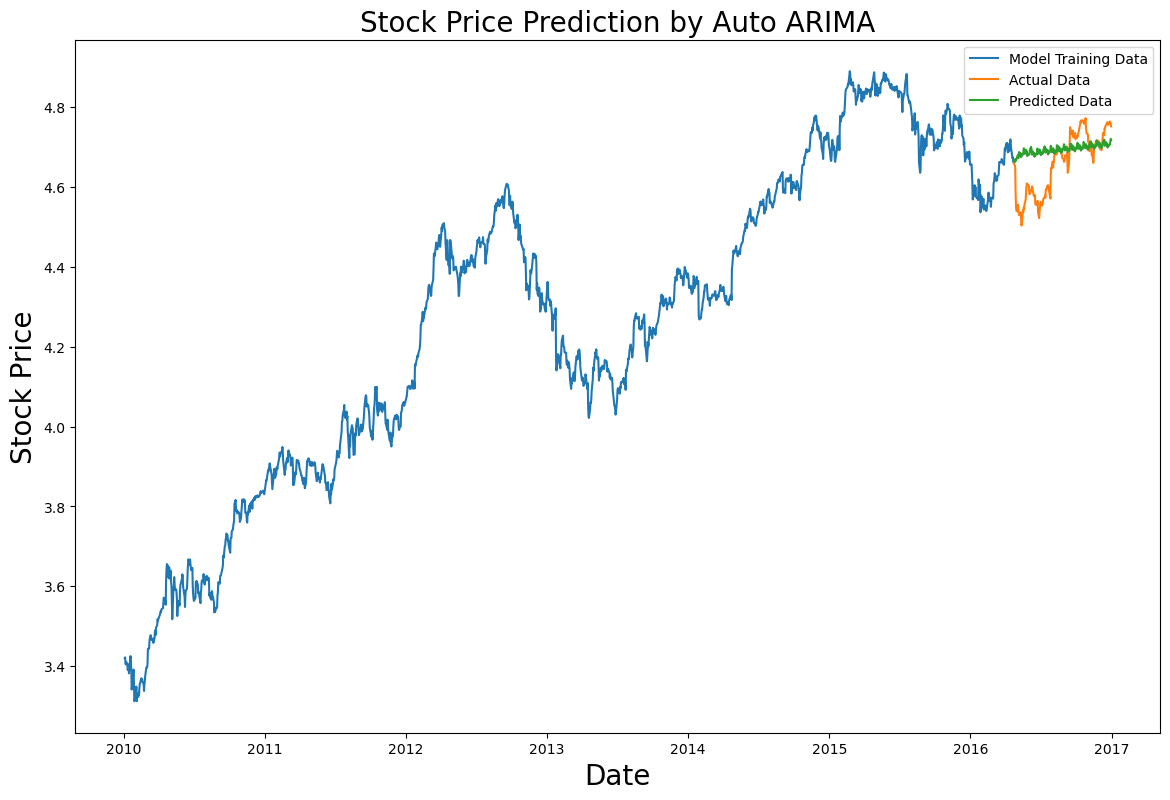

In [78]:
arima_prediction(aapl_df)

## SARIMA

In [57]:
def sarima_prediction(data):
    shape = data.shape[0]
    aapl_df = data[['close']]
    aapl_df['close'] = np.log(aapl_df['close'])  # Apply logarithmic transformation
    
    # Split the data into training and validation sets
    train_set = aapl_df.iloc[:ceil(shape * 0.9)]
    valid_set = aapl_df.iloc[ceil(shape * 0.9):]
    
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY SARIMA---------------')
    print('----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    
    training = train_set['close']
    validation = valid_set['close']
    
    # Fit the Seasonal ARIMA model
    model = auto_arima(training, 
                       start_p=0, start_q=0, 
                       max_p=3, max_q=3, 
                       d=1, 
                       seasonal=True, 
                       m=12,  # reducing the seasonality to 12 as 365 takes too long
                       start_P=0, max_P=3,
                       start_Q=0, max_Q=3,
                       D=1, trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True,
                       stepwise=True)
    
    model.fit(training)
    
    # Forecast the validation period
    forecast = model.predict(n_periods=len(validation))
    forecast.index = validation.index
    forecast = pd.DataFrame(forecast, columns=['Prediction'])
    
    # Calculate RMSE
    rms = np.sqrt(np.mean(np.power((np.array(validation) - np.array(forecast['Prediction'])), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_set['close'], label='Model Training Data')
    plt.plot(valid_set['close'], label='Actual Data')
    plt.plot(forecast['Prediction'], label='Predicted Data')
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Auto SARIMA', size=20)
    plt.legend()
    plt.show()

----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY SARIMA---------------
----------------------------------------------------------
Shape of Training Set: (1586, 1)
Shape of Validation Set: (176, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-7292.366, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-7757.476, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-7290.380, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-7898.921, Time=2.65 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-7969.930, Time=1.60 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=13.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.84 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-7971.885, Time=2.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-7899.852, Time=2.65 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, T

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


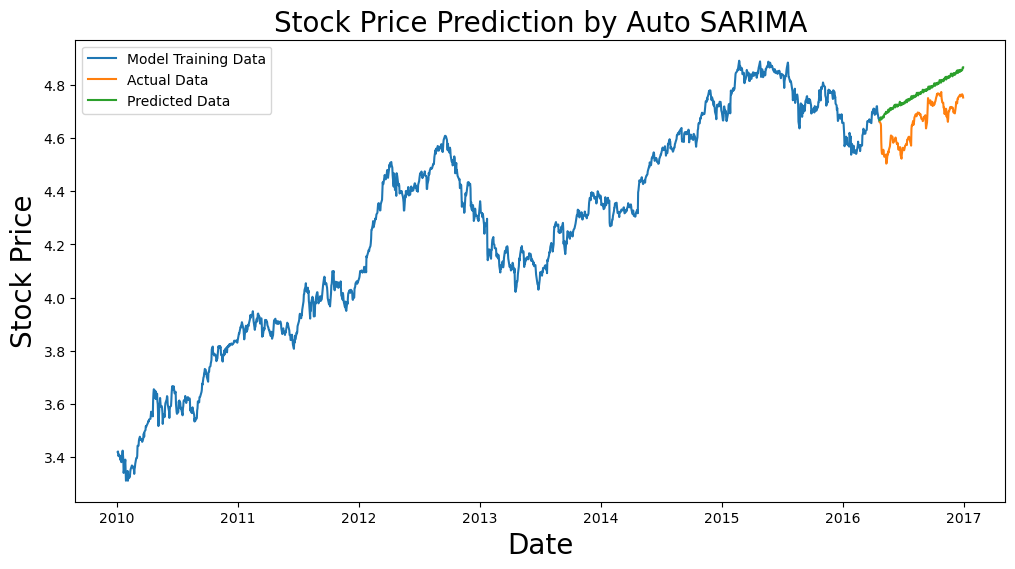

In [58]:
sarima_prediction(aapl_df)

# Moving Average

In [59]:
def moving_avg_prediction(data):
    shape = data.shape[0]
    aapl_df = data[['close']]
    aapl_df['close'] = np.log(aapl_df['close'])  # Apply logarithmic transformation
    
    train_set = aapl_df.iloc[:ceil(shape * 0.9)]
    valid_set = aapl_df.iloc[ceil(shape * 0.9):]
    
    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)
    
    preds = []
    for i in range(0, valid_set.shape[0]):
        a = train_set['close'][len(train_set) - valid_set.shape[0] + i:].sum() + sum(preds)
        b = a / (valid_set.shape[0])
        preds.append(b)
    
    rms = np.sqrt(np.mean(np.power((np.array(valid_set['close']) - preds), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    valid_set['Predictions'] = preds
    
    plt.plot(train_set['close'])
    plt.plot(valid_set[['close', 'Predictions']])
    plt.xlabel('Date', size=20)
    plt.ylabel('Log-transformed close Price', size=20)
    plt.title('Log-transformed close Price Prediction by Moving Averages', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set: (1586, 1)
Shape of Validation Set: (176, 1)
RMSE value on validation set: 0.08463943581623125
-----------------------------------------------------------
-----------------------------------------------------------


/var/folders/04/6fqt654n63g074w0l8j38g3w0000gn/T/ipykernel_61985/1358336076.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_set['Predictions'] = preds


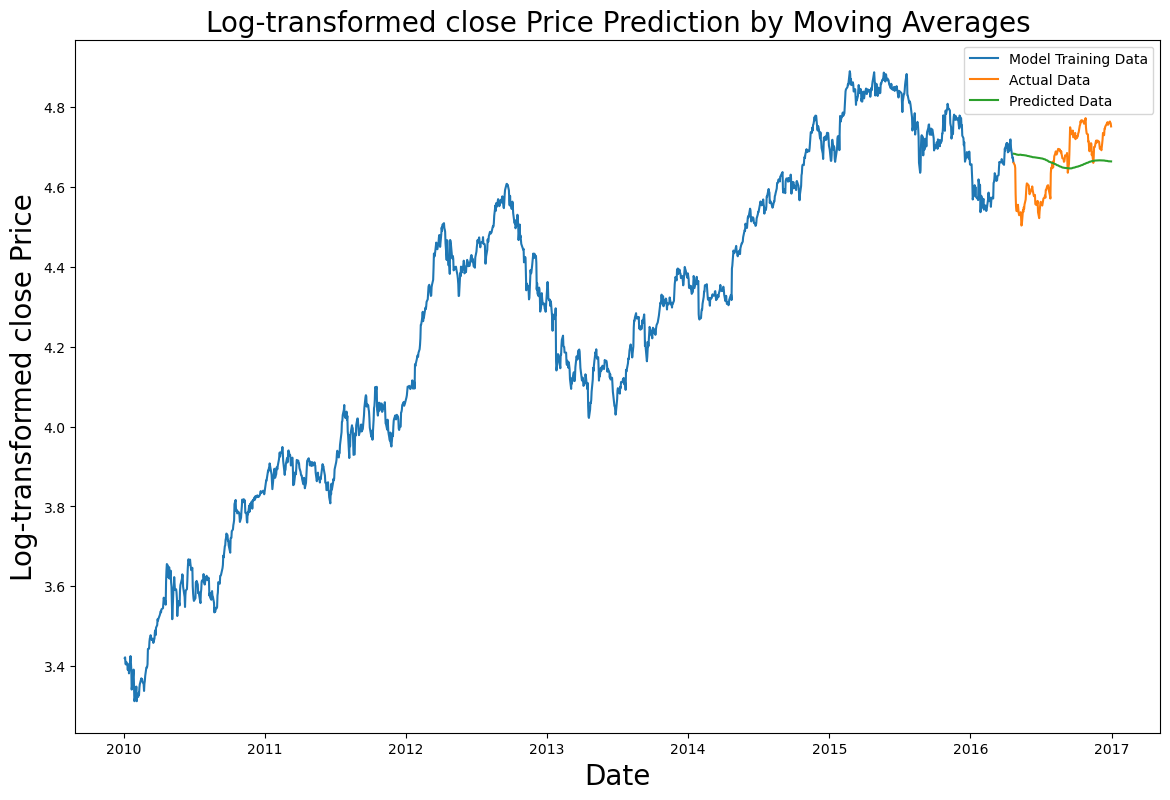

In [60]:
moving_avg_prediction(aapl_df)

## LSTM

In [62]:
shape = aapl_df.shape[0]
aapl_df=aapl_df[['close']]
dataset = aapl_df.values
train = aapl_df.iloc[:ceil(shape * 0.9)]
valid = aapl_df.iloc[ceil(shape * 0.9):]
print('-----------------------------------------------------------------------------')
print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
print('-----------------------------------------------------------------------------')
print('Shape of Training Set',train.shape)
print('Shape of Validation Set',valid.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_df)
# Create the training dataset
x_train, y_train = [], []
for i in range(40,len(train)):
    x_train.append(scaled_data[i-40:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(x_train, y_train, epochs=15, batch_size=1, verbose=2)

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (1586, 1)
Shape of Validation Set (176, 1)
Epoch 1/15


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1546/1546 - 11s - 7ms/step - loss: 0.0021
Epoch 2/15
1546/1546 - 9s - 6ms/step - loss: 8.9916e-04
Epoch 3/15
1546/1546 - 10s - 6ms/step - loss: 6.3450e-04
Epoch 4/15
1546/1546 - 10s - 6ms/step - loss: 5.1017e-04
Epoch 5/15
1546/1546 - 10s - 6ms/step - loss: 4.2501e-04
Epoch 6/15
1546/1546 - 10s - 7ms/step - loss: 3.5631e-04
Epoch 7/15
1546/1546 - 10s - 6ms/step - loss: 3.6260e-04
Epoch 8/15
1546/1546 - 10s - 7ms/step - loss: 3.3619e-04
Epoch 9/15
1546/1546 - 9s - 6ms/step - loss: 3.3632e-04
Epoch 10/15
1546/1546 - 10s - 7ms/step - loss: 3.4591e-04
Epoch 11/15
1546/1546 - 10s - 6ms/step - loss: 3.1377e-04
Epoch 12/15
1546/1546 - 10s - 6ms/step - loss: 2.9842e-04
Epoch 13/15
1546/1546 - 10s - 7ms/step - loss: 3.2122e-04
Epoch 14/15
1546/1546 - 10s - 6ms/step - loss: 3.0941e-04
Epoch 15/15
1546/1546 - 11s - 7ms/step - loss: 2.8711e-04


In [63]:
# Prepare the validation dataset
inputs = aapl_df[len(aapl_df) - len(valid) - 40:]
inputs
inputs.values.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(40,inputs.shape[0]):
    X_test.append(inputs[i-40:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Generate predictions
closing_price = model.predict(X_test)
closing_price= scaler.inverse_transform(closing_price)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print('RMSE value on validation set:',rms)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
RMSE value on validation set: 1.8498389437280696


/var/folders/04/6fqt654n63g074w0l8j38g3w0000gn/T/ipykernel_61985/4143471699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


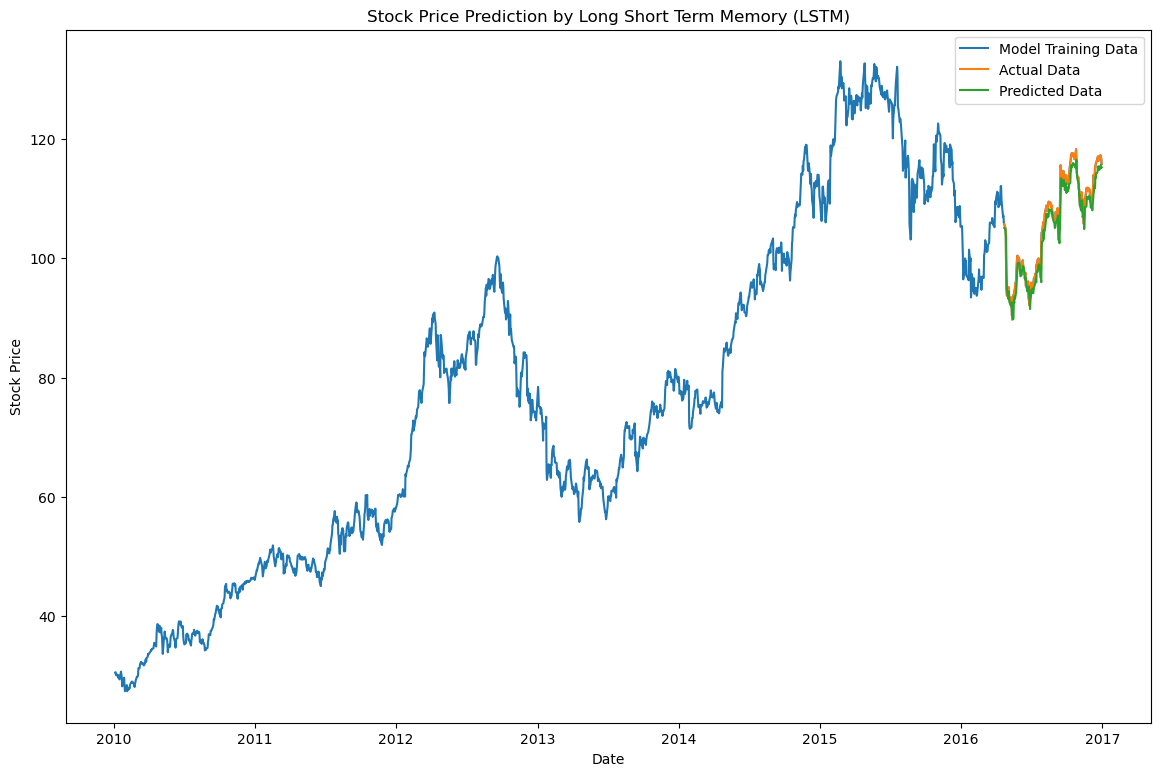

In [64]:
#Visualize the prediction
plt.figure(figsize=(14,9), dpi=100)
valid['Predictions'] = closing_price
plt.plot(aapl_df['close'])
plt.plot(valid[['close','Predictions']])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)')
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

## Hyperparameter Tuning

# Model Evaluation

ARIMA - RMSE value on validation set: 0.07782639332711733 <br>
SARIMA - RMSE value on validation set: 0.11905394717609595 <br>
Moving Average - RMSE value on validation set: 0.08463943581623125 <br>
LSTM - RMSE value on validation set: 1.8498389437280696<br>

The traditional models, particularly ARIMA, have shown to be more reliable and accurate for this dataset. If you need to deploy a model, ARIMA would be the safest and most effective choice based on these results.

# Model Saving

Arima model is saved within the arima_prediction function. 

In [74]:
# Save lstm model
model.save('lstm_model.h5')

The reason I decided to save both the ARIMA and LSTM models is based on their distinct strengths and complementary forecasting capabilities. ARIMA consistently demonstrates the lowest RMSE, indicating that it provides the most accurate and reliable predictions overall, particularly for longer-term trends. ARIMA's ability to capture the underlying patterns in the data with stability and precision makes it ideal for scenarios where consistent, long-term forecasting is essential. On the other hand, while the LSTM model shows signs of potential overfitting—evident from its higher RMSE—it is known for its ability to capture complex, non-linear relationships within the data. This makes LSTM potentially valuable for short-term predictions, where it can react more quickly to recent changes or fluctuations in the market that ARIMA might smooth over. By leveraging the strengths of both models, we can utilize ARIMA for long-term forecasts, ensuring consistency and reliability, while employing LSTM for short-term predictions where its sensitivity to recent data could provide valuable insights.